In [1]:
from oiii_fit import OIII
from fit_routine import WLAX, Lines, lines, oiii_doublet, c, z
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

(4976.097447654305, 5091.682617631499)

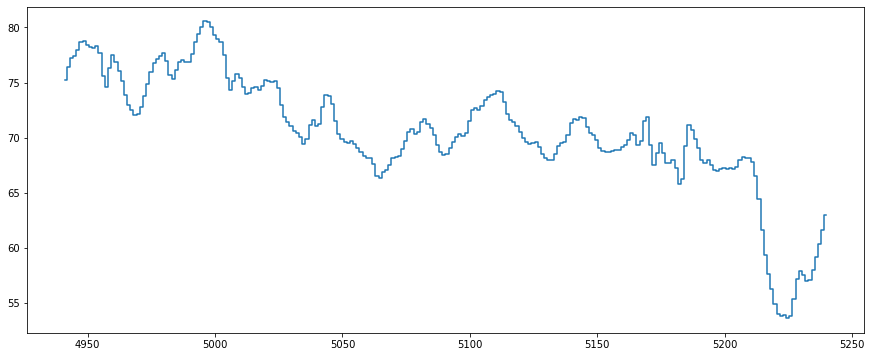

In [2]:
hdul1 = fits.open("../cube_rebin.fits")
head = hdul1[0].header
cubehdu = hdul1[0]
cubehead = cubehdu.header
cube = cubehdu.data


hdu = fits.open("../varc_rebin.fits")
varc = hdu[0].data

hdul2 = fits.open("../basespec_smoothed.fits")
basespec = hdul2[0].data

oiii = OIII('OIII', lines['OIII'][0], lines['OIII'][1], lines['OIII'][2], cube, varc, basespec)
plt.figure(figsize=(15,6))
plt.step(oiii.wlax, oiii.basespec, where='mid')
oiii.lranges

In [ ]:
quickrej = 0
snrrej = 0
runerr = 0

obs_0 = oiii.obs[0]
mask = (oiii.lranges[0] < oiii.wlax) & (oiii.wlax < oiii.lranges[1])
l_wlax = oiii.wlax[mask]
l_lranges = oiii.lranges

stime = time.time()
for i in tqdm(range(oiii.cube_x), smoothing=1):
    for j in range(oiii.cube_y):
        
        fit_spec, err_spec = oiii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej +=1
            oiii.rejcube[0,i,j] = 1
            continue

        try:
            
            popt, pcov = curve_fit(oiii_doublet, l_wlax, fit_spec[mask], p0=[500, obs_0, 2.3, 0], 
                                   bounds=([0,l_lranges[0],0,-50], [2e4, l_lranges[1], 30, 50]), 
                                   absolute_sigma=True, sigma=err_spec[mask])

            uncertainty = np.sqrt(np.diagonal(pcov))
            #snr1 = popt[0] / uncertainty[0]
            #snr2 = popt[1] / uncertainty[1]
            snr = popt[0]/uncertainty[0]
            
            #if  snr1 > 3. and snr2 > 3.:
            if snr > 3.:
                oiii.fitcube[:4,i,j] = popt[:]
                oiii.fitcube[4,i,j] = snr
                oiii.fiterrcube[:,i,j] = uncertainty
            else:
                oiii.fitcube[:4,i,j] = np.nan
                oiii.fitcube[4,i,j] = snr
  
                
                oiii.rejcube[1,i,j] = 1
                snrrej += 1
                
        except (RuntimeError, ValueError):
            oiii.set_to_nan(i, j)
            oiii.rejcube[2,i,j] = 1
            runerr +=1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)


from astropy.wcs import WCS

newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(oiii.fitcube[0], header=newhead)
newoiiihdus = [fits.ImageHDU(oiii.fitcube[i]) for i in range(1,oiii.fitcube.shape[0])]
oiiierrhdus = [fits.ImageHDU(oiii.fiterrcube[i]) for i in range(oiii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newoiiihdus + oiiierrhdus)
hdul.writeto('../OIII_fit/oiii_fit_cont.fits', overwrite = True)

rejhdus = fits.PrimaryHDU(oiii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(oiii.rejcube[i]) for i in range(1,oiii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../OIII_fit/oiii_rej_cont.fits', overwrite = True)

detectedimg = np.nan_to_num(oiii.fitcube[0])
snrrejimg = np.nan_to_num(oiii.rejcube[1])
evalimg = detectedimg + snrrejimg

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../OIII_fit/oiii_eval_cont.fits', overwrite = True)

flux0hdus = [prihdu]
velhdus = [fits.ImageHDU(c*(oiii.fitcube[1]/oiii.rest[0]-1-z))]
vdisphdus = [fits.ImageHDU(c*(oiii.fitcube[2]/oiii.rest[0]))]
resulthdus =  fits.HDUList(flux0hdus+velhdus+vdisphdus)
resulthdus.writeto('../OIII_fit/oiii_results_cont.fits', overwrite=True)



In [3]:
oiii.load_fitcubes("../OIII_fit/oiii_fit_cont.fits")

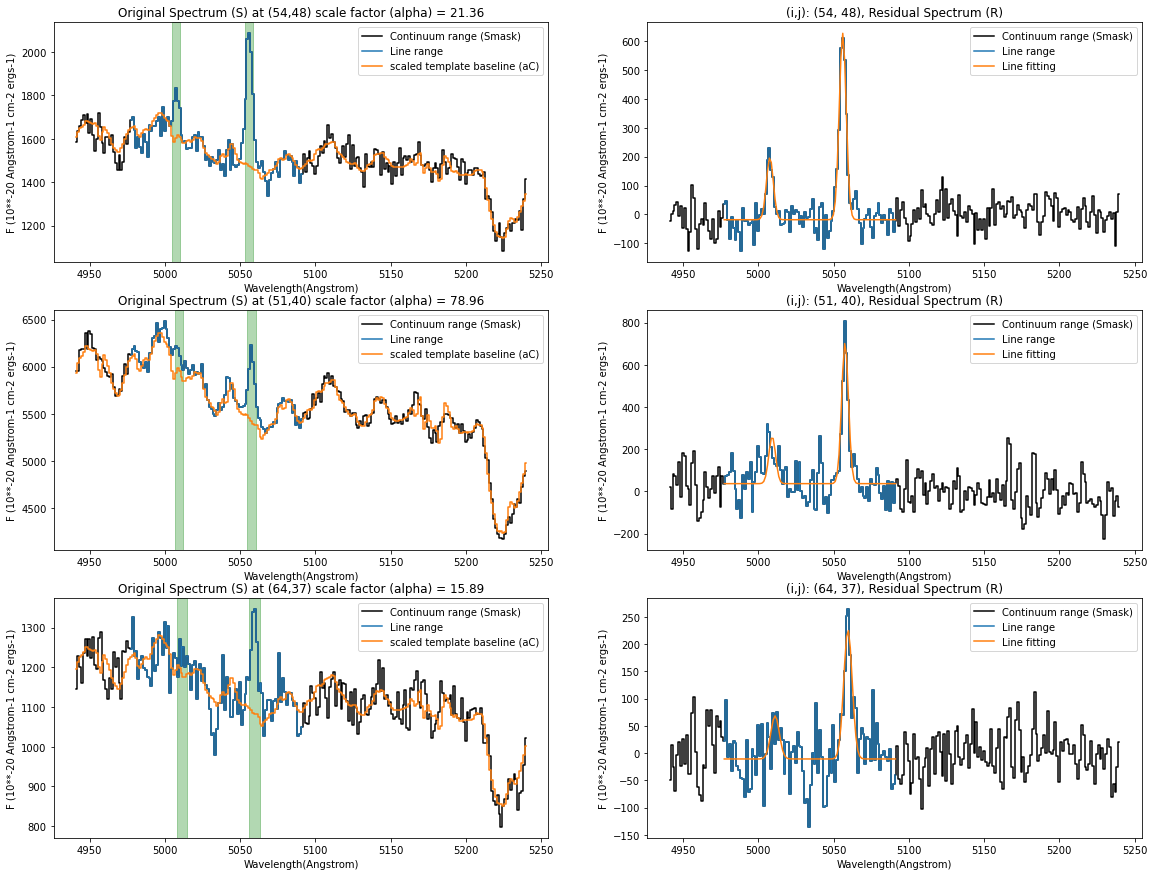

In [5]:
HIGH_CONT = [(54,48), (51,40), (64,37)]
oiii.plot_eval(HIGH_CONT, save=False, fname="OIII_high_cont")

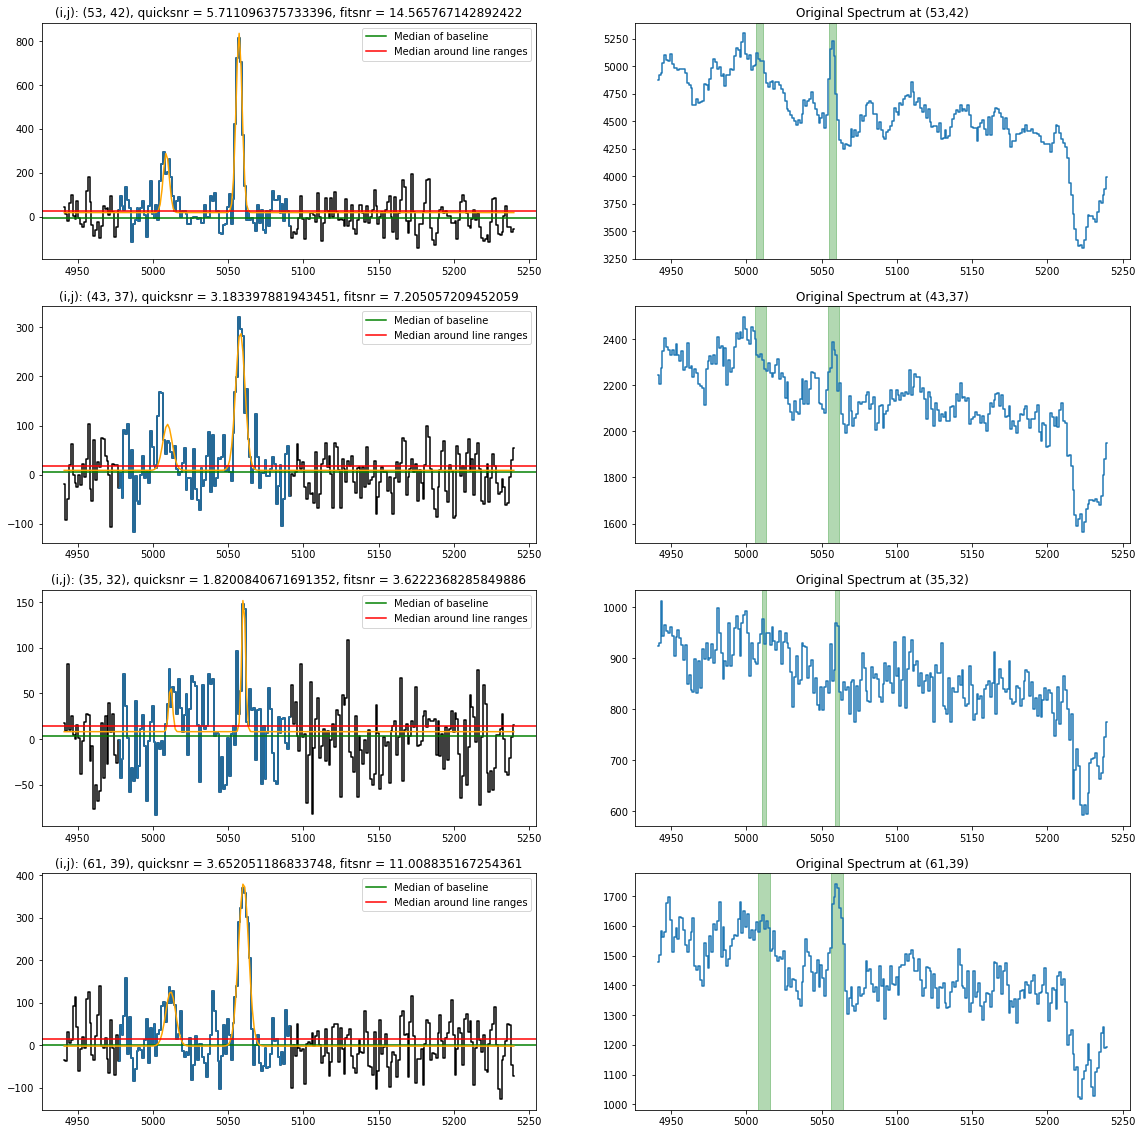

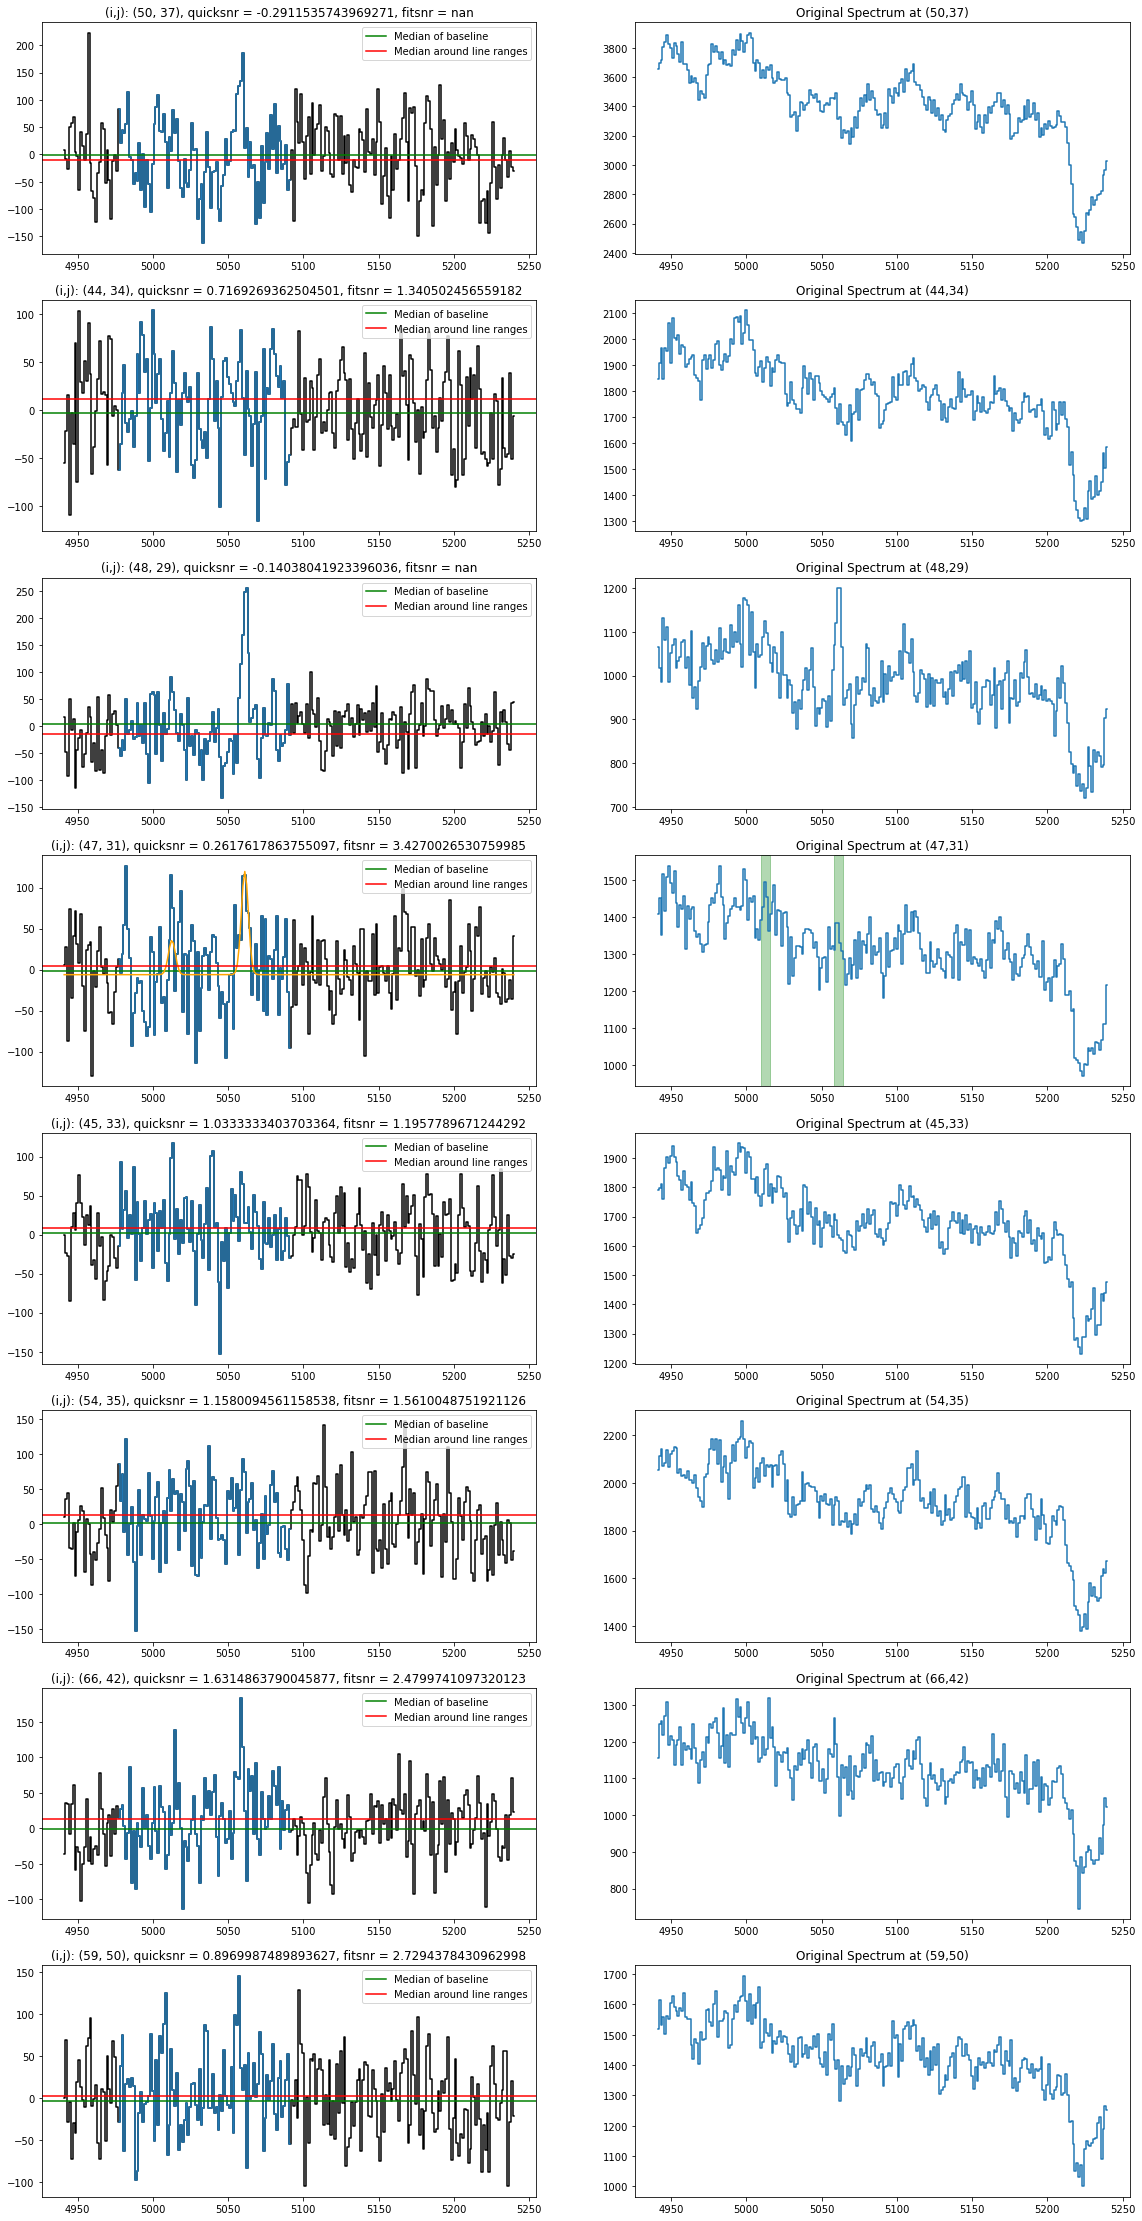

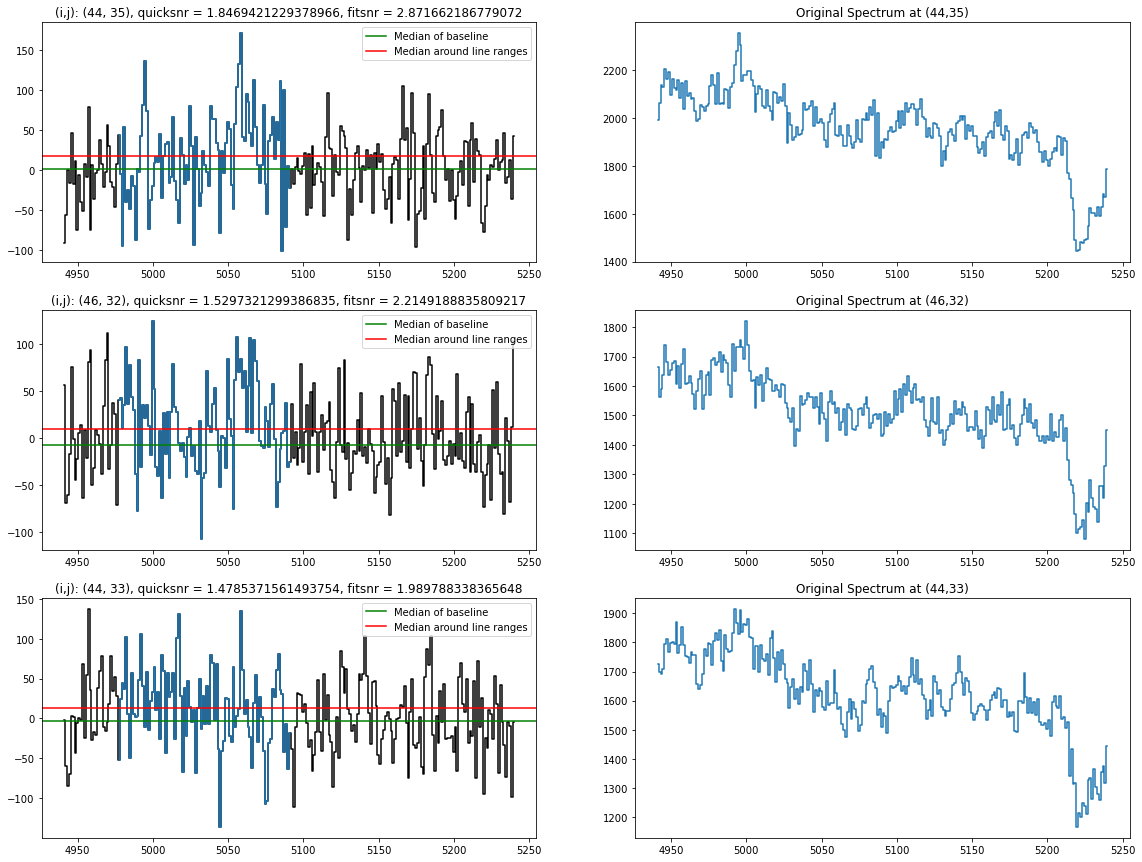

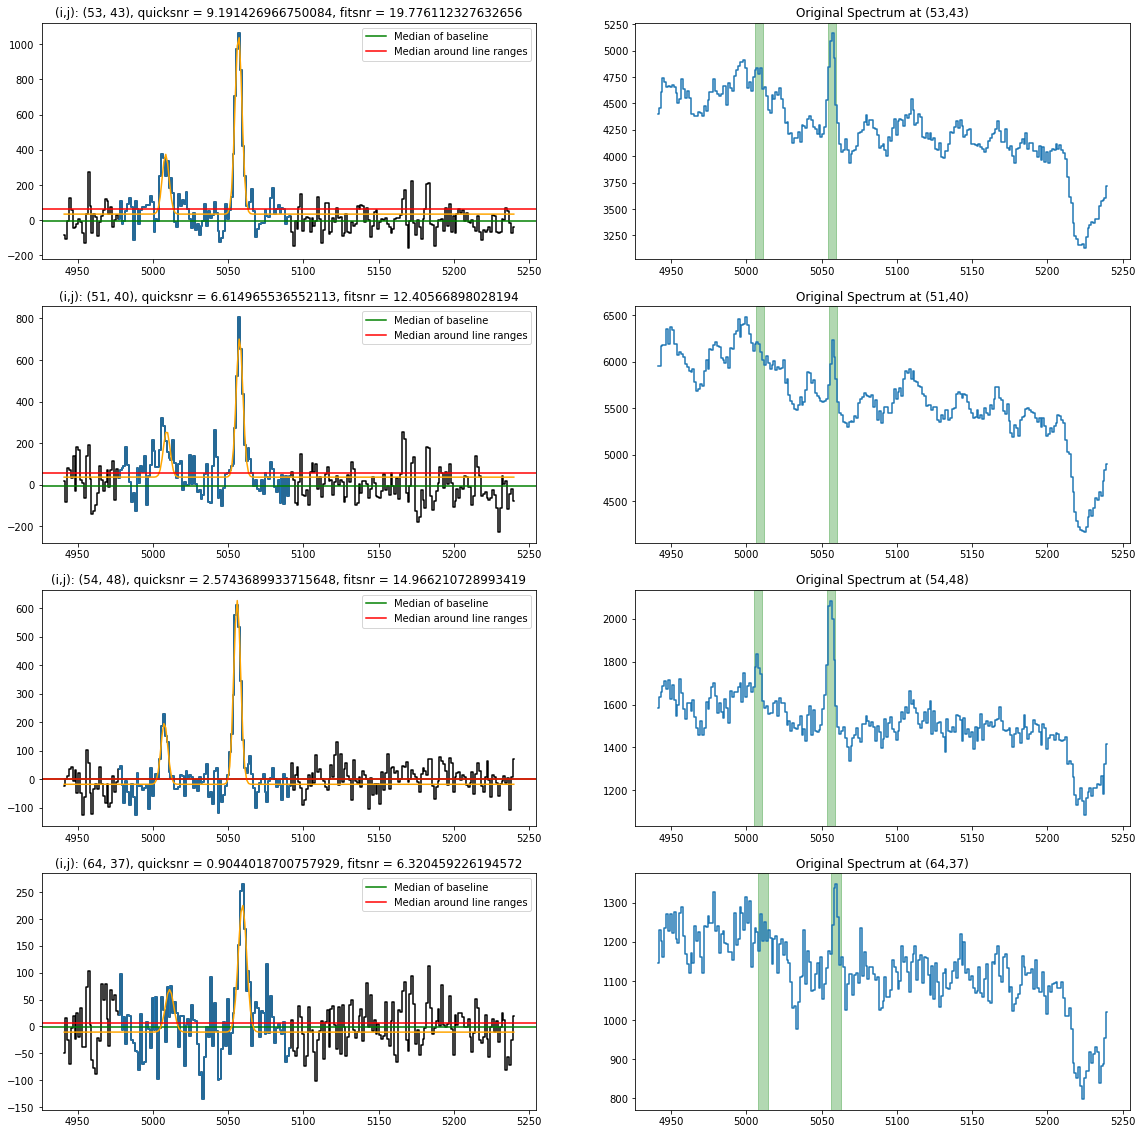

In [5]:
QUICKREJ = [(50,37), (44,34), (48,29), (47,31)]
SNRREJ = [(45, 33), (54, 35), (66, 42), (59,50)]
GOODPIXELS = [(53, 42), (43, 37), (35, 32), (61, 39)]
HOLE = [(44,35), (46,32), (44,33)]
HIGH_CONT = [(53,43), (51,40), (54,48), (64,37)]
oiii.plot_eval(GOODPIXELS, save=True, fname='OIII_good')
oiii.plot_eval(QUICKREJ+SNRREJ, save=True, fname='OIII_rej')
oiii.plot_eval(HOLE, save=True, fname="OIII_hole")
oiii.plot_eval(HIGH_CONT, save=True, fname="OIII_high_cont")

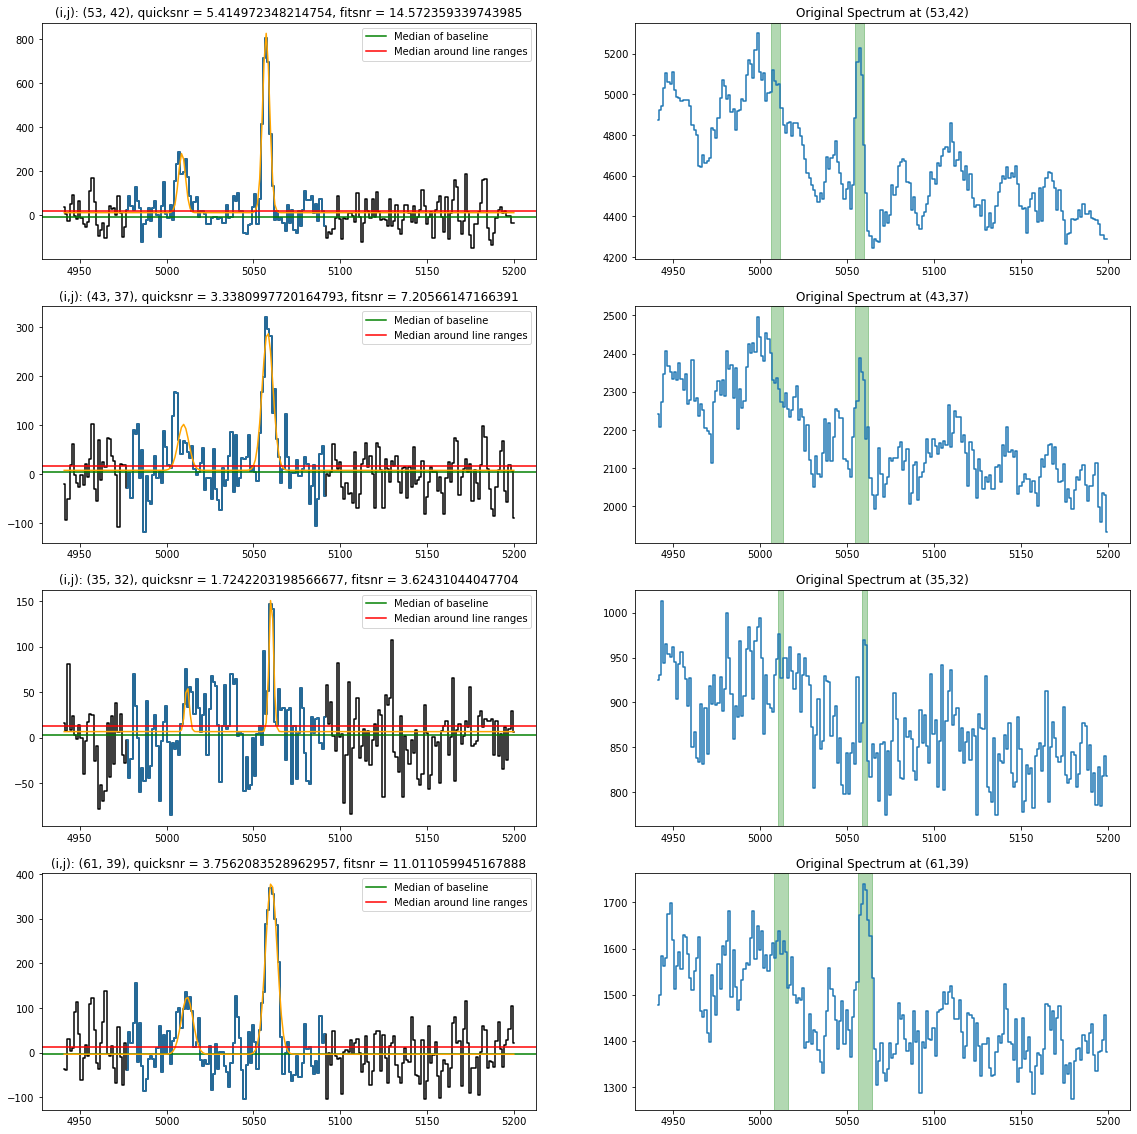

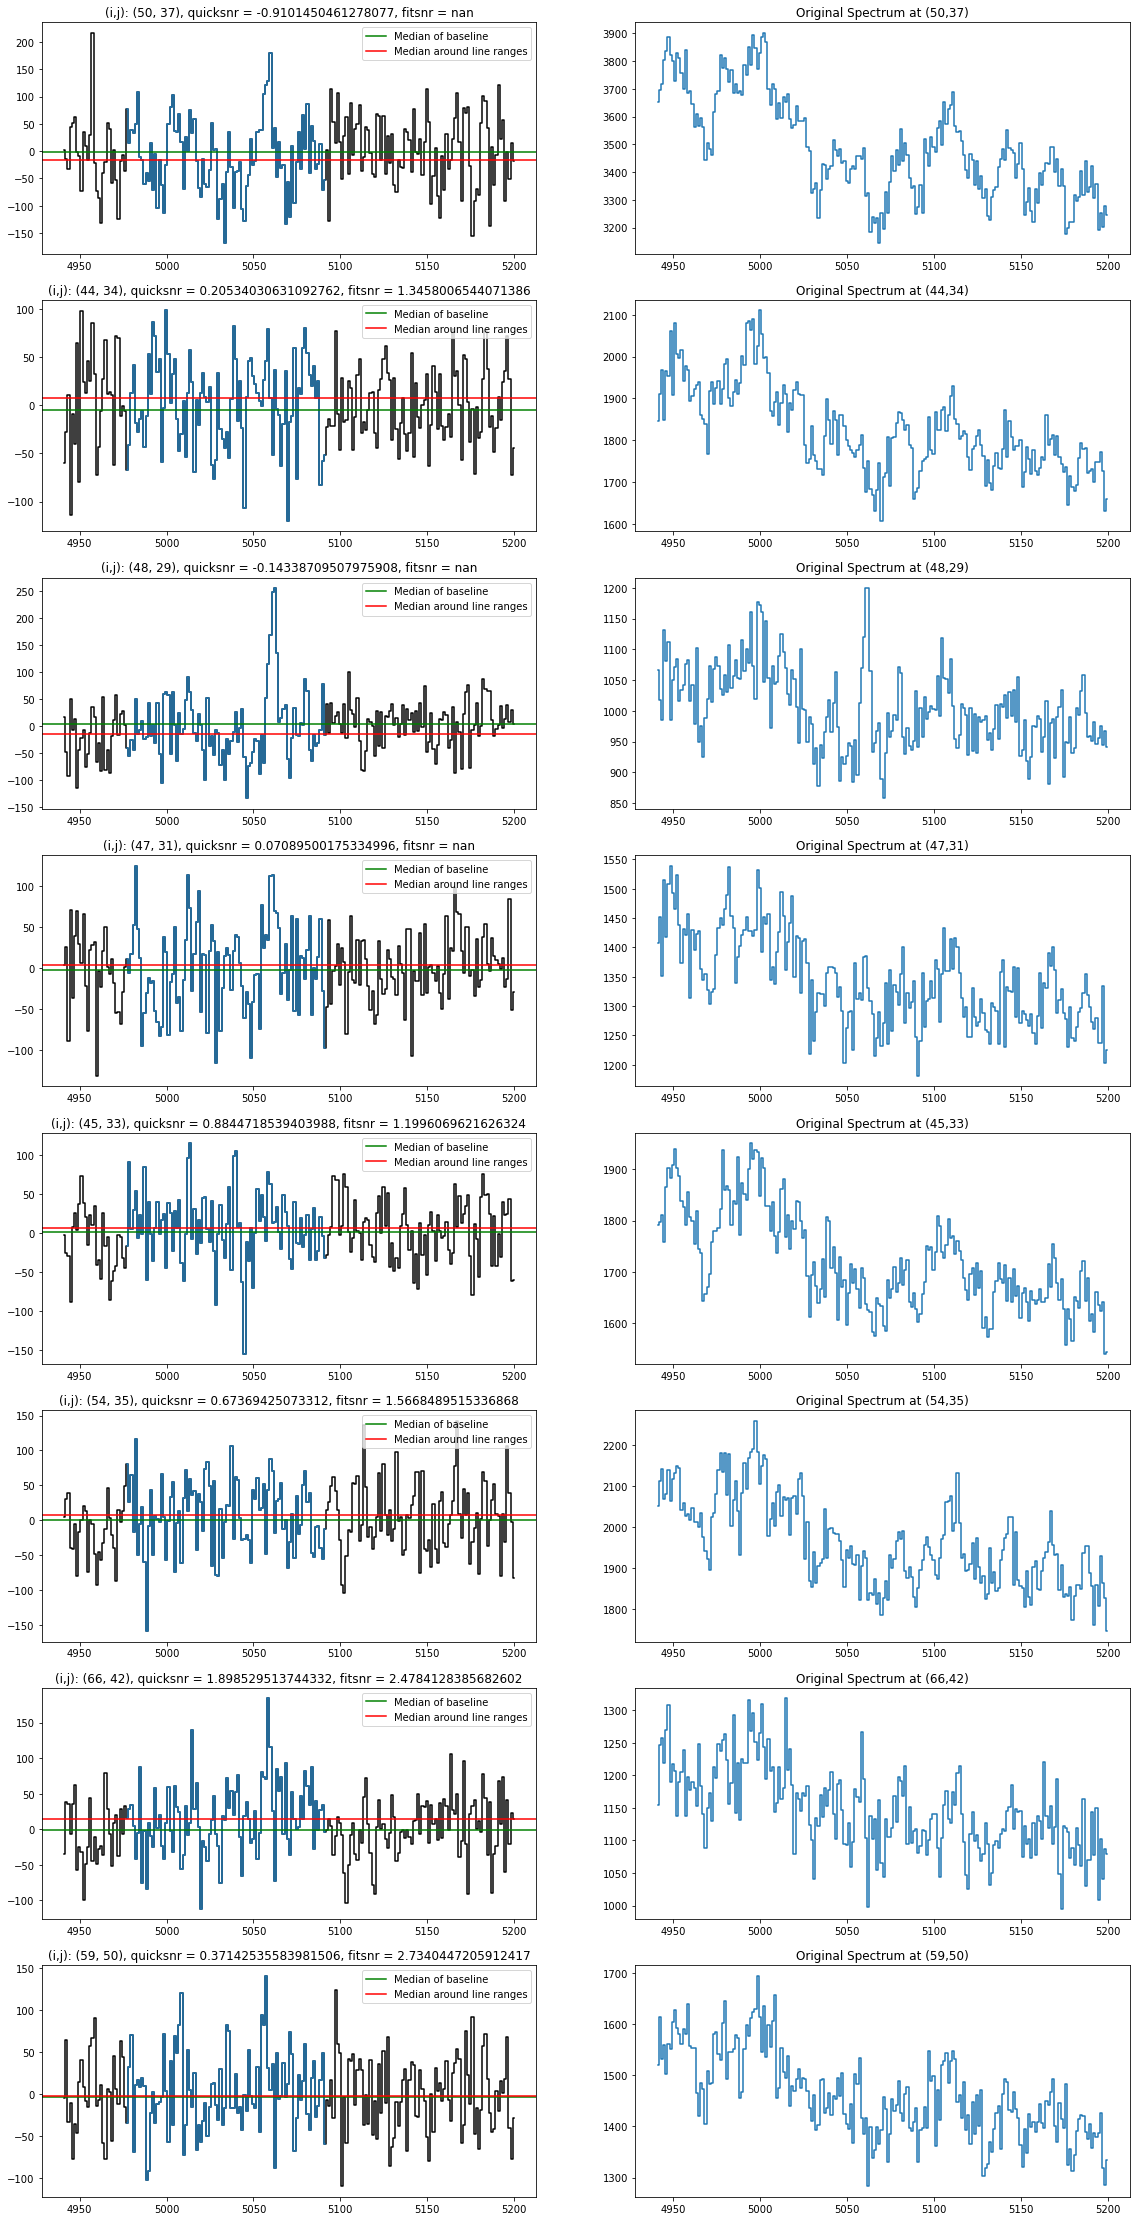

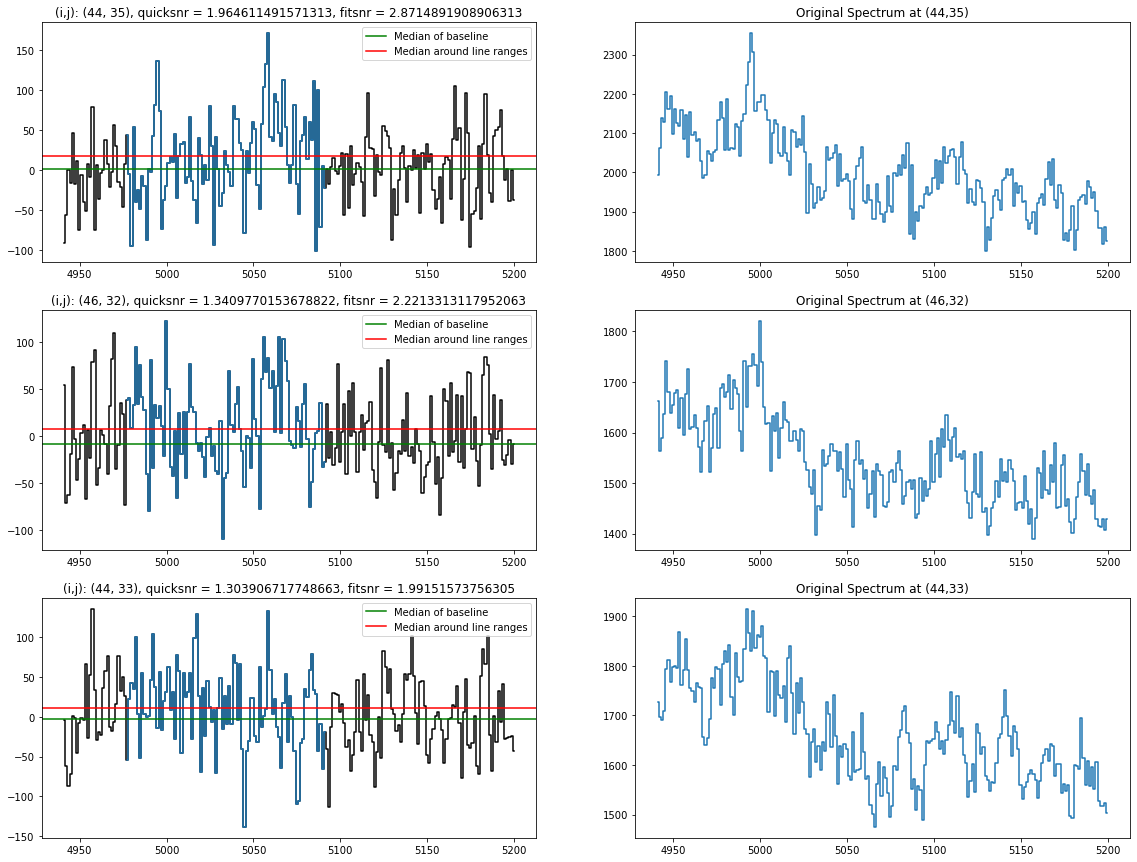

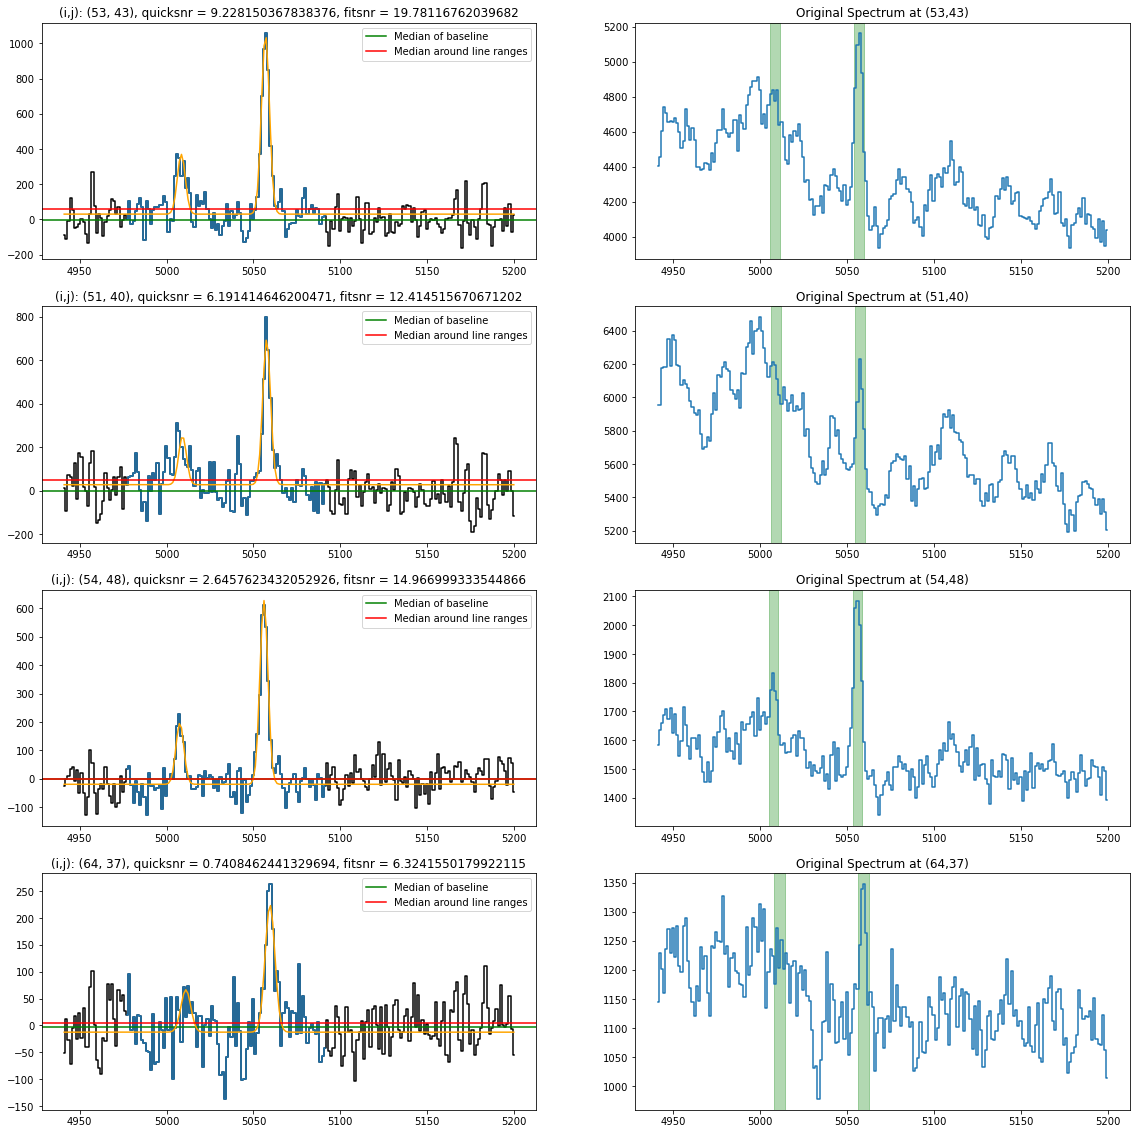

In [7]:
QUICKREJ = [(50,37), (44,34), (48,29), (47,31)]
SNRREJ = [(45, 33), (54, 35), (66, 42), (59,50)]
GOODPIXELS = [(53, 42), (43, 37), (35, 32), (61, 39)]
HOLE = [(44,35), (46,32), (44,33)]
HIGH_CONT = [(53,43), (51,40), (54,48), (64,37)]
oiii.plot_eval(GOODPIXELS, save=False, fname='OIII_good')
oiii.plot_eval(QUICKREJ+SNRREJ, save=False, fname='OIII_rej')
oiii.plot_eval(HOLE, save=False, fname="OIII_hole")
oiii.plot_eval(HIGH_CONT, save=False, fname="OIII_high_cont")